<a href="https://colab.research.google.com/github/Morfinic/PWR_1_st.2_UM/blob/master/P2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Poniższy blok pobiera dataset z Kaggle. Po uruchomieniu możliwe jest wybranie pliku, który posłuży jako klucz dostępu (Konto Kaggle -> Ustawienia -> API/Create new token).

**Datasets**
* https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images
* https://www.kaggle.com/datasets/cashbowman/ai-generated-images-vs-real-images


In [ ]:
from google.colab import files
%cd /content
files.upload()

kaggle_path = "birdy654/cifake-real-and-ai-generated-synthetic-images"

!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d $kaggle_path

import zipfile
zip_ref = zipfile.ZipFile(kaggle_path.split('/')[-1] + '.zip', 'r')
zip_ref.extractall('/content/kaggle')
zip_ref.close()

/content


Saving kaggle.json to kaggle.json
rm: cannot remove '/root/.kaggle': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images
License(s): other


In [ ]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as pimg
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from IPython.display import Image

In [ ]:
print("Devices: ", tf.config.list_physical_devices())

Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [28]:
datasetPath = "/content/kaggle"

imgDim = (32, 32)
batchSize = 500

(trainingSet, validationSet) = tf.keras.utils.image_dataset_from_directory(
    datasetPath,
    validation_split=0.1,
    subset="both",
    seed=123,
    image_size=imgDim,
    batch_size=batchSize
)

testingSet = tf.keras.utils.image_dataset_from_directory(
    datasetPath + "/test",
    seed = 500,
    image_size = imgDim,
    batch_size = batchSize
)

print("Testing set lenght:", len(trainingSet))
print("Validation set lenght:", len(validationSet))
print("Training classes: ", trainingSet.class_names)


Found 120000 files belonging to 2 classes.
Using 108000 files for training.
Using 12000 files for validation.
Found 20000 files belonging to 2 classes.
Testing set lenght: 216
Validation set lenght: 24
Training classes:  ['test', 'train']


In [29]:
def plotMetrics(history, metric):
    plt.plot(history.history[metric], label = metric)
    plt.plot(history.history['val_' + metric], label='val_' + metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

classNames = ['FAKE', 'REAL']
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)

---
# VGG16
---

In [30]:
VGG16_base = tf.keras.applications.VGG16(
    include_top = False,
    weights = "imagenet",
    input_shape = (*imgDim, 3),
    pooling = "max"
)

VGG16_base.trainable = True

input = tf.keras.Input(shape = (*imgDim, 3))

conf = VGG16_base(input, training = False)

conf = BatchNormalization(
    axis = -1,
    momentum = 0.99,
    epsilon = 0.001)(conf)

conf = Dense(
    256,
    kernel_regularizer = regularizers.l2(0.01),
    activity_regularizer = regularizers.l1(0.01),
    bias_regularizer = regularizers.l1(0.01),
    activation = "relu")(conf)

conf = Dropout(
    rate = .4,
    seed = 500)(conf)

conf = Dense(
    64,
    activation="relu")(conf)

output = Dense(1, activation = "sigmoid")(conf)

VGG16_model = tf.keras.Model(input, output)

VGG16_model.compile(optimizer = tf.keras.optimizers.Adamax(learning_rate = .001), loss = tf.keras.losses.BinaryCrossentropy(), metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

VGG16_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 512)            │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,864,577 (56.70 MB)

 Trainable params: 14,863,553 (56.70 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [31]:
print("Starting training at", datetime.now())
VGG16_history = VGG16_model.fit(
    trainingSet,
    validation_data = validationSet,
    epochs = 100,
    verbose = 1,
    callbacks = [early_stopping]
)
print("Finished trainging at", datetime.now())
VGG16_model.save("VGG16-1-gen.keras")
print("Saved trained model")

Starting training at 2025-04-13 15:10:18.717395
Epoch 1/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 52s 196ms/step - accuracy: 0.8098 - loss: 70.4007 - precision_1: 0.8328 - recall_1: 0.9651 - val_accuracy: 0.8299 - val_loss: 5.0009 - val_precision_1: 0.8299 - val_recall_1: 1.0000
Epoch 2/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 75s 186ms/step - accuracy: 0.8324 - loss: 3.8404 - precision_1: 0.8324 - recall_1: 1.0000 - val_accuracy: 0.8299 - val_loss: 3.7206 - val_precision_1: 0.8299 - val_recall_1: 1.0000
Epoch 3/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 40s 184ms/step - accuracy: 0.8328 - loss: 3.6782 - precision_1: 0.8328 - recall_1: 1.0000 - val_accuracy: 0.8299 - val_loss: 3.5674 - val_precision_1: 0.8299 - val_recall_1: 1.0000
Epoch 4/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 42s 189ms/step - accuracy: 0.8324 - loss: 3.5242 - precision_1: 0.8324 - recall_1: 1.0000 - val_accuracy: 0.8299 - val_loss: 3.4093 - val_precision_1: 0.8299 - val_recall_1: 1.0000
Epoch 5/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 40s 184ms/step - accur

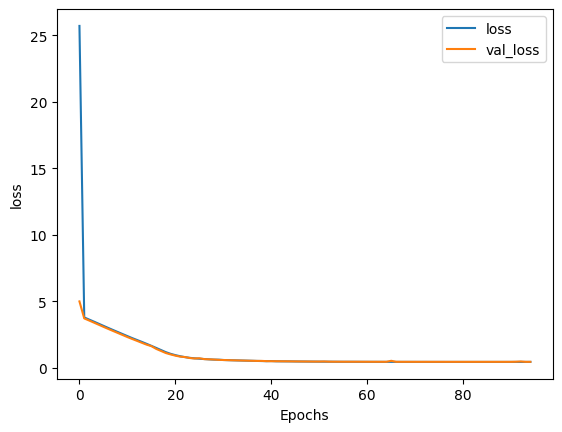

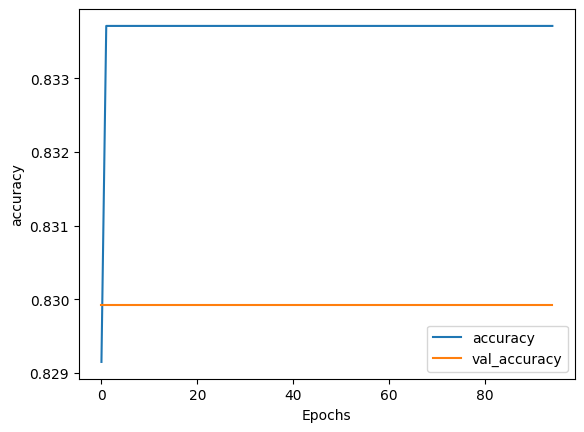

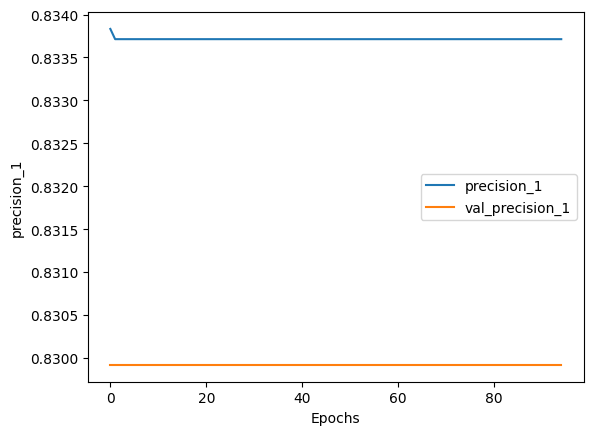

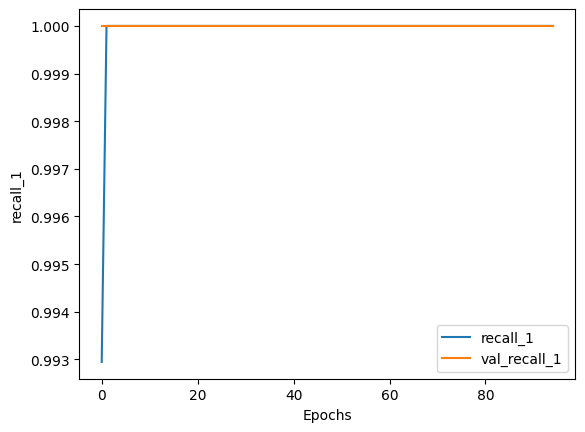

In [39]:
plotMetrics(VGG16_history, "loss")
plotMetrics(VGG16_history, "accuracy")
plotMetrics(VGG16_history, "precision_1")
plotMetrics(VGG16_history, "recall_1")

---
# Testing
---

In [33]:
%cd /content
loadedModel = tf.keras.models.load_model("VGG16-1-gen.keras")

/content


In [36]:
val_loss, val_accuracy, val_precision, val_recall = loadedModel.evaluate(testingSet)

print(f"Loss: {val_loss:.4f}")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")

40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.4960 - loss: 2.7385 - precision: 0.4960 - recall: 1.0000
Loss: 2.7338
Accuracy: 0.5000
Precision: 0.5000
Recall: 1.0000


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


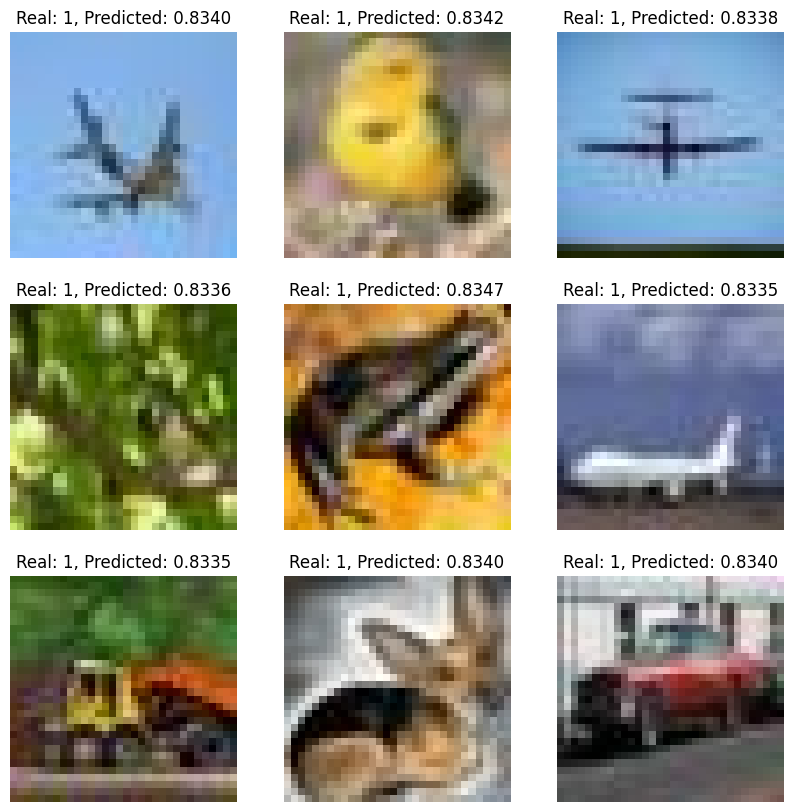

In [35]:
plt.figure(figsize=(10, 10))
for images, labels in trainingSet.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        result = loadedModel.predict(np.expand_dims(np.array(images[i]), axis = 0))
        plt.title(f"Real: {int(labels[i])}, Predicted: {result[0 ,0]:.4f}")
        plt.axis("off")

mkdir: cannot create directory ‘/content/imgTest’: File exists
/content/imgTest


Saving Bez nazwy.png to Bez nazwy (4).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


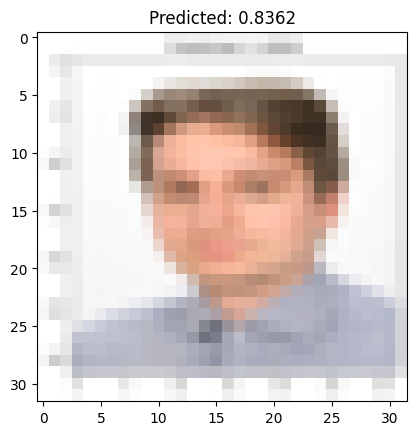

In [37]:
!mkdir /content/imgTest
%cd /content/imgTest
uploaded = files.upload()
uploadName = list(uploaded.keys())[0]

with pimg.open(uploadName) as img:
  res = img.resize(imgDim).convert('RGB')
  result = loadedModel.predict(np.expand_dims(np.array(res), axis = 0))
  plt.title(f"Predicted: {result[0 ,0]:.4f}")
  imgplot = plt.imshow(res)
  plt.show()